<a href="https://colab.research.google.com/github/anindabitm/Fowl_escapades_Zindi/blob/master/Fowl_Escapades_nb_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook to do audio classification

Thanks to Jonathan Whitaker and Radek Osmulski   for their wonderful notebooks on doing deep learning in audio

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


>Download files from Zindi

In [0]:
import os
os.chdir('/content/drive/My Drive/Fowl_audio_zindi/')

In [0]:
!mkdir train_spec test_spec
!ls

In [0]:
#the url and auth_value from the website 
import requests
import requests, zipfile

url = 'https://api.zindi.africa/v1/competitions/fowl-escapades/files/Test.zip'
myobj = {'auth_token': 'WPgEN1enJMGadXg2djyP2o7h'} 

x = requests.post(url, data = myobj,stream=True)
target_path = 'test.zip'

handle = open(target_path, "wb")
for chunk in x.iter_content(chunk_size=512):
    if chunk:  # filter out keep-alive new chunks
        handle.write(chunk)
handle.close()

In [0]:
url = "https://api.zindi.africa/v1/competitions/fowl-escapades/files/Train.zip"
myobj = {'auth_token': 'WPgEN1enJMGadXg2djyP2o7h'} 

x = requests.post(url, data = myobj,stream=True)
target_path = 'train.zip'

handle = open(target_path, "wb")
for chunk in x.iter_content(chunk_size=512):
    if chunk:  # filter out keep-alive new chunks
        handle.write(chunk)
handle.close()

In [0]:
!ls

# Unzip both the downloaded files - train.zip and test.zip 



In [0]:
!unzip train.zip

In [0]:
!unzip test.zip

In [0]:
!ls

#Import the libraries and start the magic :)

In [0]:
import os
import sys
import csv
import shutil
from pathlib import Path
from IPython.display import Audio, display
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import random
import pandas as pd
%matplotlib inline

In [0]:
#As usual we would be using fastai2
!pip install fastai2

In [0]:
#Install torchaudio also
!pip install torchaudio

In [0]:
from fastai2.torch_basics import *
from fastai2.basics import *
from fastai2.data.all import *
from fastai2.callback.all import *
from fastai2.vision.all import *
import torchaudio

>Try to seed everything. Reproducibility is sometimes an issue

In [0]:
#seed everything
seed = 42
# python RNG
random.seed(seed)
# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
# numpy RNG
np.random.seed(seed)

In [0]:
#Take a sneak peek into the sample submission file
sub = pd.read_csv('SampleSubmission.csv')
sub.head()

In [0]:
#See the train file
train = pd.read_csv('Train.csv')
train.head()

,ID,common_name
0,MBMG2C,Ring-necked Dove
1,K8LJSB,Ring-necked Dove
2,OGD9L6,Ring-necked Dove
3,581PCQ,Ring-necked Dove
4,P91M1F,Ring-necked Dove


In [0]:
# Add file names- Trick taken from John's notebook
train['file_name'] = 'Train/'+train['ID']+'.mp3'
sub['file_name'] = 'Test/'+sub['ID']+'.mp3'

# Using spectrogram to do deep learning.
>(Great repository to start learning on sound)

>https://github.com/earthspecies 

>https://github.com/mogwai/fastai_audio


In [0]:
#listen to a sound
pth = train['file_name'].sample(1).values[0]
Audio(filename=str(pth))

In [0]:
example='Train/A8KUNQ.mp3'
y, sr = librosa.load(example)
display(Audio(y, rate=sr))
sg = librosa.feature.melspectrogram(y, sr=sr,  n_fft=2048, hop_length=512, power=1.0, n_mels=128, fmin=0.0, fmax=None)
db_spec = librosa.amplitude_to_db(sg, ref=1.0, amin=1e-05, top_db=80.0)
librosa.display.specshow(db_spec, y_axis='mel', fmax=8000, x_axis='time')

In [0]:
print('Clip length is',len(y)/sr,'seconds')

Clip length is 16.393560090702948 seconds


In [0]:
#Run it only once to find out clip length and sample rate
from tqdm import tqdm
audio_len=[]
sr_list=[]
for idx in tqdm(range(len(train))):
  y,sr=librosa.load(train.loc[idx]['file_name'])
  audio_len.append(len(y))
  sr_list.append(sr)

In [0]:
#Run it only once
train['sr']=sr_list
train['audio_len']=audio_len
train.head()

,Unnamed: 0,ID,common_name,file_name,sr,audio_len
0,0,MBMG2C,Ring-necked Dove,Train/MBMG2C.mp3,22050,361478
1,1,K8LJSB,Ring-necked Dove,Train/K8LJSB.mp3,22050,265536
2,2,OGD9L6,Ring-necked Dove,Train/OGD9L6.mp3,22050,1548288
3,3,581PCQ,Ring-necked Dove,Train/581PCQ.mp3,22050,471744
4,4,P91M1F,Ring-necked Dove,Train/P91M1F.mp3,22050,870534


In [0]:
#Run it only once
train['duration']=train['audio_len']/train['sr']
train.head()

,Unnamed: 0,ID,common_name,file_name,sr,audio_len,duration
0,0,MBMG2C,Ring-necked Dove,Train/MBMG2C.mp3,22050,361478,16.393560
1,1,K8LJSB,Ring-necked Dove,Train/K8LJSB.mp3,22050,265536,12.042449
2,2,OGD9L6,Ring-necked Dove,Train/OGD9L6.mp3,22050,1548288,70.217143
3,3,581PCQ,Ring-necked Dove,Train/581PCQ.mp3,22050,471744,21.394286
4,4,P91M1F,Ring-necked Dove,Train/P91M1F.mp3,22050,870534,39.480000


In [0]:
#Run it only once
train.to_csv('train_aug.csv')

In [0]:
train=pd.read_csv('train_aug.csv')
train.head()

,Unnamed: 0,Unnamed: 0.1,ID,common_name,file_name,sr,audio_len,duration
0,0,0,MBMG2C,Ring-necked Dove,Train/MBMG2C.mp3,22050,361478,16.393560
1,1,1,K8LJSB,Ring-necked Dove,Train/K8LJSB.mp3,22050,265536,12.042449
2,2,2,OGD9L6,Ring-necked Dove,Train/OGD9L6.mp3,22050,1548288,70.217143
3,3,3,581PCQ,Ring-necked Dove,Train/581PCQ.mp3,22050,471744,21.394286
4,4,4,P91M1F,Ring-necked Dove,Train/P91M1F.mp3,22050,870534,39.480000


>Lets check the duration of these sound bytes

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


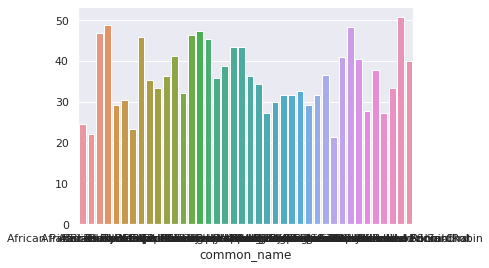

In [0]:
import seaborn as sns
sns.set()
sns.barplot(x=train.groupby(['common_name']).mean()['duration'].index,y=train.groupby(['common_name']).mean()['duration'].values)
#Varying duration bytes

In [0]:
#Run to generate spectrograms
sr = 22050
num_samples = int( 20 * sr)

In [0]:
#function to generate spectrograms of training data
import matplotlib
matplotlib.use('agg')
def mel_spec_img(fn,num_samples):
  fig = plt.figure(frameon=False,figsize=[8, 8])
  ax = fig.add_subplot(111)
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.set_frame_on(False)
  y, sr = librosa.load(fn)
  y = librosa.util.fix_length(y, num_samples)
  sg = librosa.feature.melspectrogram(y, sr=sr,  n_fft=2048, hop_length=512, power=1.0, n_mels=128, fmin=0.0, fmax=None)
  db_spec = librosa.amplitude_to_db(sg, ref=1.0, amin=1e-05, top_db=80.0)
  db_spec = (db_spec - db_spec.min())/(db_spec.max() - db_spec.min()) * 255
  ax=librosa.display.specshow(db_spec, y_axis='mel', fmax=8000, x_axis='time')
  ax.figure.savefig('./train_spec/{}.png'.format(fn.split('/')[1].split('.')[0]),dpi=64,bbox_inches = 'tight',pad_inches = 0)
  plt.close(fig)

In [0]:
#Call spectrogram generation function to generate images for training data
from tqdm import tqdm
for idx in tqdm(range(len(train))):
  mel_spec_img(train.loc[idx]['file_name'],num_samples=num_samples)

100%|██████████| 1857/1857 [22:22<00:00,  1.38it/s]


In [0]:
#function to generate spectrograms of test data
import matplotlib
matplotlib.use('agg')
def mel_spec_img(fn,num_samples):
  fig = plt.figure(frameon=False,figsize=[8, 8])
  ax = fig.add_subplot(111)
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.set_frame_on(False)
  y, sr = librosa.load(fn)
  y = librosa.util.fix_length(y, num_samples)
  sg = librosa.feature.melspectrogram(y, sr=sr,  n_fft=2048, hop_length=512, power=1.0, n_mels=128, fmin=0.0, fmax=None)
  db_spec = librosa.amplitude_to_db(sg, ref=1.0, amin=1e-05, top_db=80.0)
  db_spec = (db_spec - db_spec.min())/(db_spec.max() - db_spec.min()) * 255
  ax=librosa.display.specshow(db_spec, y_axis='mel', fmax=8000, x_axis='time')
  ax.figure.savefig('./test_spec/{}.png'.format(fn.split('/')[1].split('.')[0]),dpi=64,bbox_inches = 'tight',pad_inches = 0)
  plt.close(fig)

In [0]:
#Call spectrogram generation function to generate images for test data
from tqdm import tqdm
for idx in tqdm(range(len(sub))):
  mel_spec_img(sub.loc[idx]['file_name'],num_samples=num_samples)

In [0]:
def get_items(path): return get_files(path)

def get_y(fn): 
  id=str(fn).split('/')[1].split('.')[0]
  cn=train.loc[train['ID']==id]['common_name'].tolist()[0]
  return cn

#Using StratifiedKfold cross validation to reduce overfitting

In [0]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
X=train['file_name'].copy()
y=train['common_name'].copy()
fold = 0
for train_index, test_index in skf.split(X, y):
  fold+= 1
  print('In fold',fold)
  print("TRAIN LENGTH:", len(train_index), "VALIDATION LENGTH:", len(test_index))
  train[f'fold_{fold}_valid']=False
  train.loc[test_index,f'fold_{fold}_valid']=True

In [0]:
train.head(10)

In [0]:
def dataloader(mask):
  db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_items,
    get_y=get_y,
    splitter=MaskSplitter(mask),
    item_tfms = Resize(512),
    )
  return (db.dataloaders(Path('./train_spec/'),bs=8))

In [0]:
final_preds=np.zeros((sub.shape[0],sub.shape[1]-1))
fold = 0
for fold in range(5):
  fold+=1
  print('In fold:',fold)
  mask=list(train[f'fold_{fold}_valid'].copy())
  dls=dataloader(mask)
  dls.show_batch()
  learn = cnn_learner(dls,xresnet50,metrics=[accuracy,top_k_accuracy])
  learn.fine_tune(10)
  dl_test=learn.dls.test_dl(get_items(Path('./test_spec/')))
  preds, _ = learn.get_preds(dl=dl_test)
  print('Prediction completed in fold: {}'.format(str(fold)))
  final_preds+=preds.numpy()
  
final_preds=final_preds/5

In [0]:
final_preds.shape
pd.DataFrame(final_preds,columns=sub.columns[1:]).head()

In [0]:
import gc
learn = None
gc.collect()
torch.cuda.empty_cache()

In [0]:
sub.drop(['file_name'],axis=1,inplace=True)
sub.head()

In [0]:
sub1=sub.copy()
for birds_pred in dls.vocab:
  sub1[birds_pred]=final_preds[:,dls.vocab.o2i[birds_pred]]

In [0]:
sub1.head()

# Making a submission

Save the model's predicted probabilities to a file following the sample submission format. This can be submitted on Zindi.

In [0]:
# Check shape
sub1.shape

(911, 41)

In [0]:
# Save 
sub1.to_csv('submission_fowl_cv.csv', index=False)